# Load Data

In [3]:
# Libraries
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
# Loading data from csv
df = pd.read_csv('Sarcasm_Model_Dataset.csv')
df.head()

# Splitting data into test and train (80:20 split)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)

# Frame Classifier

# Audio Classifier

In [60]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from IPython.display import Audio
from skimage import color

#Extract relevant columns
train_tone_df = train_df[['tone', 'sarcasm']]
train_tone_df.head()
test_tone_df = test_df[['tone', 'sarcasm']]
test_tone_df.head()

,tone,sarcasm
12,1_1001.wav,False
80,1_11699.wav,True
33,1_2216.wav,False
5,1_410.wav,False
188,2_53.wav,False


In [79]:
#Define helper functions
#https://medium.com/@hasithsura/audio-classification-d37a82d6715
#https://github.com/jeffprosise/Deep-Learning/blob/master/Audio%20Classification%20(CNN).ipynb
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
  wav,sr = librosa.load(file_path,sr=sr)
  if wav.shape[0]<10*sr:
    wav=np.pad(wav,int(np.ceil((10*sr-wav.shape[0])/2)),mode='reflect')
  else:
    wav=wav[:10*sr]
  spec=librosa.feature.melspectrogram(y=wav, sr=sr, n_fft=n_fft, hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
  spec_db=librosa.power_to_db(spec,top_db=top_db)
  return spec_db

def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps) #z score normalization
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

In [80]:
#Convert .wav files to spectrogram images
audio_dir = 'audio_data'

def get_spec_images(filenames, directory):
    spec_images = []
    for filename in filenames:
        if filename.endswith(".wav"):
            file_path = os.path.join(directory, filename)
            spectrogram = get_melspectrogram_db(file_path)
            spec_image = spec_to_image(spectrogram)
            spec_images.append(spec_image)
    return spec_images

train_spec_images = get_spec_images(train_df['tone'], audio_dir)
train_spec_labels = train_tone_df['sarcasm']

test_spec_images = get_spec_images(test_df['tone'], audio_dir)
test_spec_labels = test_tone_df['sarcasm']

In [120]:
#divide the pixel values by 255
tone_train_norm = np.array(train_spec_images) 
tone_test_norm = np.array(test_spec_images)

#one-hot-encode the labels
tone_train_encoded = to_categorical(train_spec_labels)
tone_test_encoded = to_categorical(test_spec_labels)

In [146]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, BatchNormalization, Dropout

#Build Model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 862, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='sigmoid'))  # Output layer with 1 unit for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()

In [150]:
batch = 5
epochs = 15

#Fit the model
tone_model = model.fit(tone_train_norm, tone_train_encoded, batch_size=batch, epochs=epochs, validation_split = 0.2)

Epoch 1/15
27/27 [==============================] - 31s 1s/step - loss: 0.5155 - accuracy: 0.6642 - val_loss: 0.5693 - val_accuracy: 0.6176
Epoch 2/15
27/27 [==============================] - 31s 1s/step - loss: 0.5214 - accuracy: 0.6642 - val_loss: 0.5693 - val_accuracy: 0.6176
Epoch 3/15
27/27 [==============================] - 31s 1s/step - loss: 0.7340 - accuracy: 0.6418 - val_loss: 0.8504 - val_accuracy: 0.5882
Epoch 4/15
27/27 [==============================] - 31s 1s/step - loss: 0.5522 - accuracy: 0.6269 - val_loss: 1.2833 - val_accuracy: 0.5882
Epoch 5/15
27/27 [==============================] - 30s 1s/step - loss: 0.5533 - accuracy: 0.6194 - val_loss: 0.8744 - val_accuracy: 0.5882
Epoch 6/15
27/27 [==============================] - 30s 1s/step - loss: 0.5700 - accuracy: 0.5970 - val_loss: 0.8236 - val_accuracy: 0.5882
Epoch 7/15
27/27 [==============================] - 30s 1s/step - loss: 0.5509 - accuracy: 0.6269 - val_loss: 1.4978 - val_accuracy: 0.5588
Epoch 8/15
27/27 [==

[]

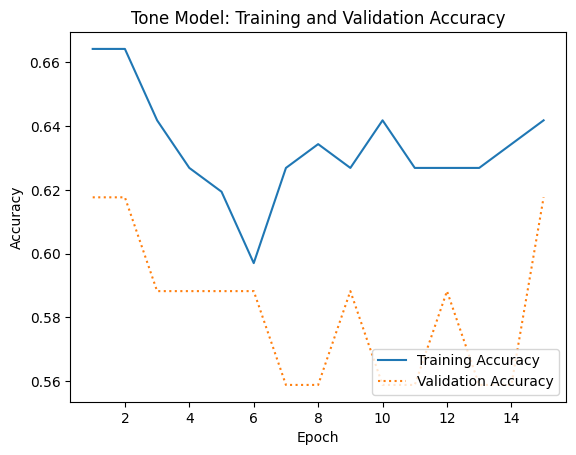

In [152]:
accuracy = tone_model.history['accuracy']
validation_acc = tone_model.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, '-', label='Training Accuracy')
plt.plot(epochs, validation_acc, ':', label='Validation Accuracy')
plt.title('Tone Model: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [175]:
predictions = model.predict(tone_test_norm)

#Filter to only positive class
tone_predictions = predictions[:, 1]

2/2 [==============================] - 1s 281ms/step


<class 'numpy.ndarray'>


# Text Classifer

# Sarcasm Detection Model Using Late Fusion